#### Script to download DEM and calculate DEM-derived rasters with whiteboxtools

In [1]:
import sys
import os
sys.path.append('/Applications/WhiteboxTools_darwin_m_series/WBT')  # Path to whitebox_tools.py
from whitebox_tools import WhiteboxTools
import rasterio
import numpy as np
from tools import dem_from_mml, burn_water_into_dem, rasterize_water_bodies, raster_to_watershed_shapefile
wbt = WhiteboxTools()
wbt.set_working_dir('/Users/jpnousu/WBT_data')
apifile = r'/Users/jpnousu/WBT_data/apikey.txt'
apikey = np.loadtxt(apifile, dtype='str') # api-key loaded from a txt-file

In [2]:
# parameters
resolution = 32
out_fd = f'/Users/jpnousu/WBT_data/pallas_{resolution}/'
subset = [370000,7537500,390000,7557500] # coordinate box of the dem
roads_file = r'/Users/jpnousu/WBT_data/shapes/clipped_MTK-tie_19-01-23_tieviiva.shp'
streams_file = '/Users/jpnousu/WBT_data/shapes/merged_rivers_streams_2D.shp'
streams_o_file = r'/Users/jpnousu/WBT_data/shapes/stream_outlets.shp'
rivers_file = r'/Users/jpnousu/WBT_data/shapes/clipped_MTK-virtavesi_19-01-23_virtavesialue.shp'
lakes_file = r'/Users/jpnousu/WBT_data/shapes/clipped_MTK-vakavesi_24-08-01_jarvi.shp'
drop = 1.0

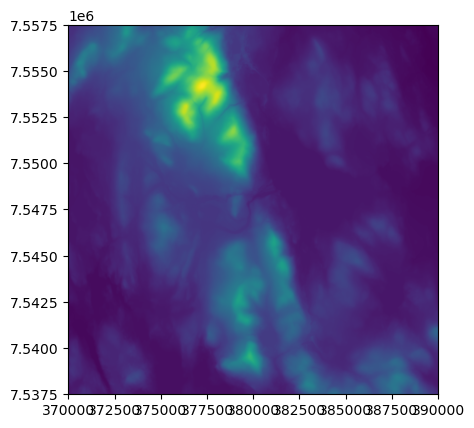

In [3]:
# download dem
scalefactor = 2./resolution
_, dem_path = dem_from_mml(out_fd,
             subset,
             apikey,
             layer='korkeusmalli_2m',
             form='image/tiff',
             scalefactor=scalefactor,
             plot=True,
             save_in='tif')

In [4]:
# burn streams at roads
process = 'culverts'
dem_base = os.path.splitext(dem_path)[0]
dem_culverts_path = f"{dem_base}_{process}.tif"

wbt.burn_streams_at_roads(
    dem_path, 
    streams_file,
    roads_file,
    dem_culverts_path,
    width=50.0, 
)

./whitebox_tools --run="BurnStreamsAtRoads" --wd="/Users/jpnousu/WBT_data" --dem='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m.tif' --streams='/Users/jpnousu/WBT_data/shapes/merged_rivers_streams_2D.shp' --roads='/Users/jpnousu/WBT_data/shapes/clipped_MTK-tie_19-01-23_tieviiva.shp' --output='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts.tif' --width='50.0' -v --compress_rasters=False

*********************************
* Welcome to BurnStreamsAtRoads *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading streams and roads data...
Reading DEM raster...
Rasterizing Streams: 0%
Rasterizing Streams: 1%
Rasterizing Streams: 2%
Rasterizing Streams: 3%
Rasterizing Streams: 4%
Rasterizing Streams: 5%
Rasterizing Streams: 6%
Rasterizing Streams: 7%
Rasterizing Streams: 8%
Rasterizing Streams: 9%
Rasterizing Streams: 10%
Rasterizing Streams: 11%
Rasterizing Streams: 12%
Rasterizing Streams: 13%
Rasterizing Streams: 14%
R

0

In [5]:
# Rasterizing the lake, stream and river shapefiles into a .tif
water_file = rasterize_water_bodies(
    stream_file=streams_file,
    river_file=rivers_file,
    lake_file=lakes_file,
    ref_raster=dem_culverts_path,
)

Hydrological mask raster saved to: /Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_streams_rivers_lakes.tif


In [6]:
# Rasterizing the stream and river shapefiles into a .tif
stream_river_file = rasterize_water_bodies(
    stream_file=streams_file,
    river_file=rivers_file,
    ref_raster=dem_culverts_path,
)

Hydrological mask raster saved to: /Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_streams_rivers.tif


In [7]:
# Using the previously rasterized file to 'burn' water elements into the dem
dem_culverts_stream_path = burn_water_into_dem(dem_culverts_path, water_file, drop=1.0)

Modified DEM saved to: /Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water.tif


In [8]:
# Breach depressions
process = 'no_deps'
dem_base = os.path.splitext(dem_culverts_stream_path)[0]
dem_breached_path = f"{dem_base}_{process}.tif"

wbt.breach_depressions_least_cost(
    dem_culverts_stream_path, 
    dem_breached_path, 
    dist=1000, 
    max_cost=1000.0,
)

./whitebox_tools --run="BreachDepressionsLeastCost" --wd="/Users/jpnousu/WBT_data" --dem='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water.tif' --output='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps.tif' --dist='1000' --max_cost='1000.0' --min_dist --fill -v --compress_rasters=False

*****************************************
* Welcome to BreachDepressionsLeastCost *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Finding pits: 0%
Finding pits: 1%
Finding pits: 2%
Finding pits: 3%
Finding pits: 4%
Finding pits: 5%
Finding pits: 6%
Finding pits: 7%
Finding pits: 8%
Finding pits: 9%
Finding pits: 10%
Finding pits: 11%
Finding pits: 12%
Finding pits: 13%
Finding pits: 14%
Finding pits: 15%
Finding pits: 16%
Finding pits: 17%
Finding pits: 18%
Finding pits: 19%
Finding pits: 20%
Finding pits: 21%
Finding pits: 22%
Finding pits: 23%
Finding pits: 24%
Fin

0

In [9]:
# Slope
process = 'slope'
dem_base = os.path.splitext(dem_breached_path)[0]
slope_path = f"{dem_base}_{process}.tif"

wbt.slope(
    dem_breached_path, 
    slope_path, 
    units="degrees", 
)

./whitebox_tools --run="Slope" --wd="/Users/jpnousu/WBT_data" --dem='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps.tif' --output='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_slope.tif' --units=degrees -v --compress_rasters=False

****************************
* Welcome to Slope         *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

0

In [10]:
# Calculating flow directions

# D8
process = 'flowp_d8'
dem_base = os.path.splitext(dem_breached_path)[0]
flow_pointer_path_d8 = f"{dem_base}_{process}.tif"

wbt.d8_pointer(
    dem_breached_path, 
    flow_pointer_path_d8,
)

# Dinf
process = 'flowp_dinf'
dem_base = os.path.splitext(dem_breached_path)[0]
flow_pointer_path_dinf = f"{dem_base}_{process}.tif"

wbt.d_inf_pointer(
    dem_breached_path, 
    flow_pointer_path_dinf,
)

./whitebox_tools --run="D8Pointer" --wd="/Users/jpnousu/WBT_data" --dem='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps.tif' --output='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_flowp_d8.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 

0

In [11]:
# Calculating flow accumulation

# D8
process = 'flowacc_d8'
dem_base = os.path.splitext(dem_breached_path)[0]
flow_acc_path_d8 = f"{dem_base}_{process}.tif"

wbt.d8_flow_accumulation(
    dem_breached_path,
    flow_acc_path_d8,
    out_type="specific contributing area",
)

# Dinf
process = 'flowacc_dinf'
dem_base = os.path.splitext(dem_breached_path)[0]
flow_acc_path_dinf = f"{dem_base}_{process}.tif"

wbt.d_inf_flow_accumulation(
    dem_breached_path,
    flow_acc_path_dinf,
    out_type="specific contributing area",
)

./whitebox_tools --run="D8FlowAccumulation" --wd="/Users/jpnousu/WBT_data" --input='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps.tif' --output='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_flowacc_d8.tif' --out_type=specific contributing area -v --compress_rasters=False

*********************************
* Welcome to D8FlowAccumulation *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Flow directions: 0%
Flow directions: 1%
Flow directions: 2%
Flow directions: 3%
Flow directions: 4%
Flow directions: 5%
Flow directions: 6%
Flow directions: 7%
Flow directions: 8%
Flow directions: 9%
Flow directions: 10%
Flow directions: 11%
Flow directions: 12%
Flow directions: 13%
Flow directions: 14%
Flow directions: 15%
Flow directions: 16%
Flow directions: 17%
Flow directions: 18%
Flow directions: 19%
Flow directions: 20%
Flow directions: 21%
Flow directions: 22%
Flow direct

0

In [12]:
# Calculating TWI

# D8
process = 'twi_d8'
dem_base = os.path.splitext(dem_breached_path)[0]
twi_d8_path = f"{dem_base}_{process}.tif"

wbt.wetness_index(
    flow_acc_path_d8, 
    slope_path, 
    twi_d8_path, 
)

# Dinf
process = 'twi_dinf'
dem_base = os.path.splitext(dem_breached_path)[0]
twi_dinf_path = f"{dem_base}_{process}.tif"

wbt.wetness_index(
    flow_acc_path_dinf, 
    slope_path, 
    twi_dinf_path, 
)

./whitebox_tools --run="WetnessIndex" --wd="/Users/jpnousu/WBT_data" --sca='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_flowacc_d8.tif' --slope='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_slope.tif' --output='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_twi_d8.tif' -v --compress_rasters=False

****************************
* Welcome to WetnessIndex  *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Pr

0

In [13]:
# Snapping the stream outlets to the flow accumulation raster
process = 'snap'
base = os.path.splitext(dem_breached_path)[0]
snapped_path = f"{base}_{process}.shp"
snap_dist = resolution*2
wbt.snap_pour_points(
    streams_o_file, 
    flow_acc_path_d8, 
    snapped_path, 
    snap_dist, 
)

./whitebox_tools --run="SnapPourPoints" --wd="/Users/jpnousu/WBT_data" --pour_pts='/Users/jpnousu/WBT_data/shapes/stream_outlets.shp' --flow_accum='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_flowacc_d8.tif' --output='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_snap.shp' --snap_dist='64' -v --compress_rasters=False

*****************************
* Welcome to SnapPourPoints *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 25%
Progress: 50%
Progress: 75%
Progress: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.0s


0

In [14]:
# Delineating the watersheds
process = 'watershed'
base = os.path.splitext(dem_breached_path)[0]
ws_raster = f"{base}_{process}.tif"

wbt.watershed(
    flow_pointer_path_d8, 
    snapped_path, 
    ws_raster, 
)

./whitebox_tools --run="Watershed" --wd="/Users/jpnousu/WBT_data" --d8_pntr='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_flowp_d8.tif' --pour_pts='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_snap.shp' --output='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_watershed.tif' -v --compress_rasters=False

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Locating pour points: 0%
Locating pour points: 25%
Locating pour points: 50%
Locating pour points: 75%
Locating pour points: 100%
Initializing: 0%
Initializing: 1%
Initializing: 2%
Initializing: 3%
Initializing: 4%
Initializing: 5%
Initializing: 6%
Initializing: 7%
Initializing: 8%
Initializing: 9%
Initializing: 10%
Initializing: 11%
Initializing: 12%
Initializing: 13%
Initializing: 14%
Initializing: 15%
Initializing: 16%
Initializing: 17%
Initia

0

In [15]:
# Delineated raster to shapefile
ws_shapefile = raster_to_watershed_shapefile(ws_raster)

Watershed shapefile saved to: /Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_watershed.shp


In [16]:
# Delineating subbasins (seems useless..)
process = 'subbasins'
base = os.path.splitext(dem_breached_path)[0]
output = f"{base}_{process}.tif"

wbt.subbasins(
    flow_pointer_path_d8, 
    stream_river_file, 
    output
)

./whitebox_tools --run="Subbasins" --wd="/Users/jpnousu/WBT_data" --d8_pntr='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_flowp_d8.tif' --streams='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_streams_rivers.tif' --output='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_subbasins.tif' -v --compress_rasters=False

****************************
* Welcome to Subbasins     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Processing streams: 0%
Processing streams: 1%
Processing streams: 2%
Processing streams: 3%
Processing streams: 4%
Processing streams: 5%
Processing streams: 6%
Processing streams: 7%
Processing streams: 8%
Processing streams: 9%
Processing streams: 10%
Processing streams: 11%
Processing streams: 12%
Processing streams: 13%
Processing streams: 14%
Processing streams: 15%
Processing streams: 16%
Processing streams: 17%
Processing streams: 18%
Processin

0

In [17]:
# Delineating strahlerbasins (seems useless..)
process = 'strahlerbasins'
base = os.path.splitext(dem_breached_path)[0]
output = f"{base}_{process}.tif"

wbt.strahler_order_basins(
    flow_pointer_path_d8,
    stream_river_file,
    output
)

./whitebox_tools --run="StrahlerOrderBasins" --wd="/Users/jpnousu/WBT_data" --d8_pntr='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_flowp_d8.tif' --streams='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_streams_rivers.tif' --output='/Users/jpnousu/WBT_data/pallas_32/korkeusmalli_32m_culverts_water_no_deps_strahlerbasins.tif' -v --compress_rasters=False

**********************************
* Welcome to StrahlerOrderBasins *
* Powered by WhiteboxTools       *
* www.whiteboxgeo.com            *
**********************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%


0